In [ ]:
import tensorflow as tf
#This import was used to count my specific labels
from collections import Counter

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
#import seaborn as sns

**Imports for image reading**

In [ ]:
#This was used for image manipulation in the early stages of investigation
import PIL
from PIL import Image
from matplotlib import image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.0.0


Imports for modeling:

In [ ]:
#Imports for building out models

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, confusion_matrix, multilabel_confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
from google.colab import drive

In [ ]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%matplotlib inline

## Target Data (and associated EDA features
---

**Note: According to the README from the original data post, all images have been converted to 1024 X 1024 matrix images, so don't worry about what the origin image pixel sizes are for import.**

This can of course still be useful for EDA (perhaps higher image pixel sizes led to higher incidence of findings?

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive/'Colab Notebooks/data'

Data_Entry_2017_v2020.csv


In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/data/Data_Entry_2017_v2020.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.columns = df.columns.map({col:col.lower().replace(' ','_') for col in df.columns})

In [ ]:
df.head()

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [ ]:
df.shape

(112120, 11)

In [ ]:
df.finding_labels.nunique()

836

In [ ]:
df.finding_labels.unique()[:20]

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax'],
      dtype=object)

In [ ]:
df.finding_labels.value_counts(normalize = True)[:20]

No Finding                           0.538361
Infiltration                         0.085150
Atelectasis                          0.037594
Effusion                             0.035275
Nodule                               0.024126
Pneumothorax                         0.019568
Mass                                 0.019078
Effusion|Infiltration                0.014297
Atelectasis|Infiltration             0.012041
Consolidation                        0.011684
Atelectasis|Effusion                 0.010391
Pleural_Thickening                   0.010043
Cardiomegaly                         0.009748
Emphysema                            0.007956
Infiltration|Nodule                  0.007394
Atelectasis|Effusion|Infiltration    0.006573
Fibrosis                             0.006484
Edema                                0.005601
Cardiomegaly|Effusion                0.004317
Consolidation|Infiltration           0.003933
Name: finding_labels, dtype: float64

In [ ]:
df.isnull().sum()

image_index                    0
finding_labels                 0
follow-up_#                    0
patient_id                     0
patient_age                    0
patient_gender                 0
view_position                  0
originalimage[width            0
height]                        0
originalimagepixelspacing[x    0
y]                             0
dtype: int64

In [ ]:
#df.finding_labels = df.finding_labels.apply(lambda x: x.split('|'))

In [ ]:
df.finding_labels.nunique()

836

In [ ]:
df.finding_labels[50:55]

50                 Emphysema|Pneumothorax
51               Atelectasis|Pneumothorax
52                           Pneumothorax
53    Cardiomegaly|Emphysema|Pneumothorax
54                             No Finding
Name: finding_labels, dtype: object

In [ ]:
labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
          'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']

In [ ]:
#Trying to reduce the number of unique groupings by alphabetizing them 
#This makes, say "Edema, Cardiomegaly" and "Cardiomegaly, Edema" the same label rather than two unique ones
def alphabetize(string):
    labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
          'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']
    grouping = [finding for finding in labels if finding in string]
    grouping = []
    for i in labels:
        if i in string:
            grouping.append(i)
    return grouping

In [ ]:
tuple(df.finding_labels[50].split('|'))

('Emphysema', 'Pneumothorax')

In [ ]:
df.finding_labels[12]

'Mass|Nodule'

In [ ]:
alphabetize(df.finding_labels[12])

['Mass', 'Nodule']

In [ ]:
alphabetize('Nodule|Mass')

['Mass', 'Nodule']

In [ ]:
alphabetize(df.finding_labels[0])

['Cardiomegaly']

In [ ]:
df.finding_labels[112092]

'Cardiomegaly|Effusion|Emphysema|Pneumothorax'

In [ ]:
alphabetize(df.finding_labels[112092])

['Cardiomegaly', 'Effusion', 'Pneumothorax', 'Emphysema']

In [ ]:
df['finding_labels_clean'] = df.finding_labels.apply(alphabetize)

In [ ]:
df.finding_labels.nunique()

836

Method for building generator and this count are from [this site](https://godatadriven.com/blog/keras-multi-label-classification-with-imagedatagenerator/)

In [ ]:

labels_count = Counter(label for lbs in df['finding_labels_clean'] for label in lbs)

In [ ]:
labels_count #112120 total

Counter({'Atelectasis': 11559,
         'Cardiomegaly': 2776,
         'Consolidation': 4667,
         'Edema': 2303,
         'Effusion': 13317,
         'Emphysema': 2516,
         'Fibrosis': 1686,
         'Hernia': 227,
         'Infiltration': 19894,
         'Mass': 5782,
         'No Finding': 60361,
         'Nodule': 6331,
         'Pleural_Thickening': 3385,
         'Pneumonia': 1431,
         'Pneumothorax': 5302})

In [ ]:
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}

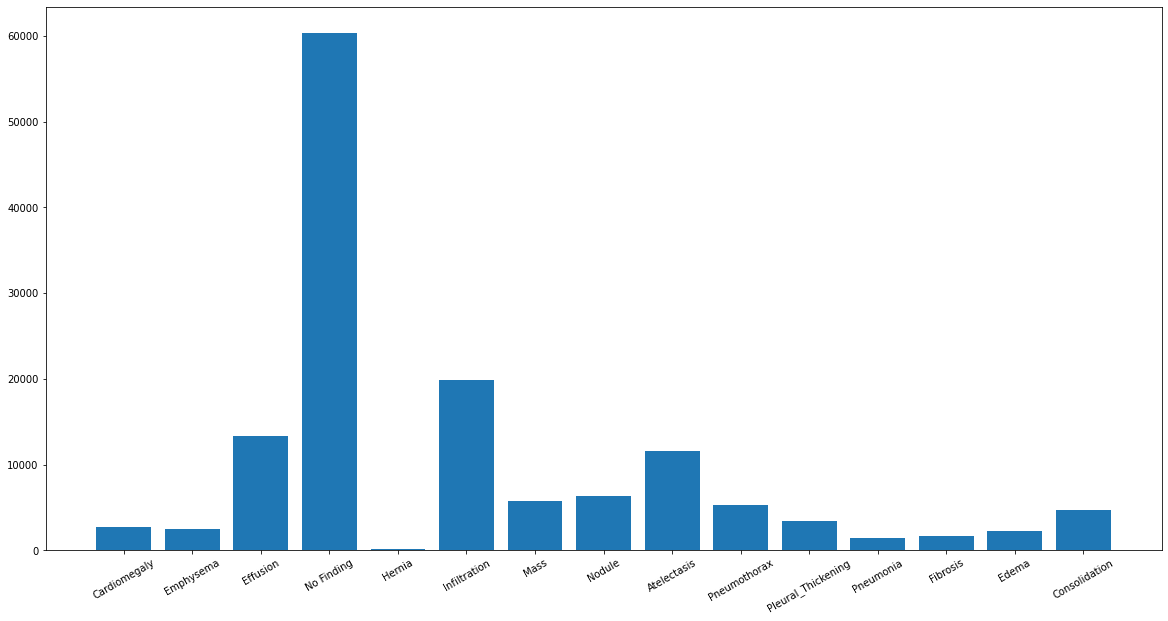

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(labels_count.keys(),labels_count.values())
plt.xticks(rotation = 30);

In [ ]:
df.finding_labels_clean[112092]

['Cardiomegaly', 'Effusion', 'Pneumothorax', 'Emphysema']

In [ ]:

df.finding_labels_clean.value_counts()[-7:].index

Index([                           ['Atelectasis', 'Mass', 'Nodule', 'Pneumonia'],
                                             ['Mass', 'Consolidation', 'Hernia'],
                   ['Atelectasis', 'Infiltration', 'Mass', 'Nodule', 'Fibrosis'],
                        ['Atelectasis', 'Infiltration', 'Emphysema', 'Fibrosis'],
                               ['Effusion', 'Infiltration', 'Mass', 'Emphysema'],
                                     ['Infiltration', 'Mass', 'Nodule', 'Edema'],
       ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening']],
      dtype='object')

In [ ]:
df.finding_labels_clean.values.tolist()[:10]

[['Cardiomegaly'],
 ['Cardiomegaly', 'Emphysema'],
 ['Cardiomegaly', 'Effusion'],
 ['No Finding'],
 ['Hernia'],
 ['Hernia'],
 ['Infiltration', 'Hernia'],
 ['Hernia'],
 ['Hernia'],
 ['Hernia']]

In [ ]:
df.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,[Cardiomegaly]
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"[Cardiomegaly, Effusion]"
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,[No Finding]
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,[Hernia]
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,[Hernia]
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,"[Infiltration, Hernia]"
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,[Hernia]
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,[Hernia]
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143,[Hernia]


In [ ]:
not_labels = [i for i in df.columns[2:] if i not in labels]
not_labels

['follow-up_#',
 'patient_id',
 'patient_age',
 'patient_gender',
 'view_position',
 'originalimage[width',
 'height]',
 'originalimagepixelspacing[x',
 'y]',
 'finding_labels_clean']

## Image data (Modelling Features)
---

From [Importing Image Data into Numpy Arrays](https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)

## DEBUG
----

In [ ]:
#It appears that these images are not in the correct order. This is going to cause some random subset to be missing the values.
#Much worse, it's going to make my array images completely out of order. This is bad
df[df.image_index == '00000003_000.png']

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean
11,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,[Hernia]


In [ ]:
int(df.image_index[0].split('_')[0])

1

In [ ]:
df.image_index[0].split('_')[1].split('.')[0]

'000'

In [ ]:
df[['image_index', 'patient_id', 'follow-up_#']] #Thank God. They already have this together. I will need to sort by these to 
#get the image indices back together

,image_index,patient_id,follow-up_#
0,00000001_000.png,1,0
1,00000001_001.png,1,1
2,00000001_002.png,1,2
3,00000002_000.png,2,0
4,00000003_001.png,3,0
...,...,...,...
112115,00030801_001.png,30801,1
112116,00030802_000.png,30802,0
112117,00030803_000.png,30803,0
112118,00030804_000.png,30804,0


In [ ]:
arranger = df.sort_values(by = ['patient_id', 'follow-up_#'])

In [ ]:
arranger.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,[Cardiomegaly]
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"[Cardiomegaly, Effusion]"
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,[No Finding]
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,[Hernia]
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,[Hernia]
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,"[Infiltration, Hernia]"
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,[Hernia]
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,[Hernia]
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143,[Hernia]


This is still not fixing the issue. Sadly, the patient number and follow up numbers are not correctly matching the image naming protocols. This is why my images and theirs are out of order. So, I WILL have to manually restructure this to match the image filing system. Hooray...

In [ ]:
#making a file patient num and file image num column, then sorting
print(int(df.image_index[0].split('_')[0]))
df['fpt_num'] = df.image_index.apply(lambda x: int(x.split('_')[0]))
df['fimg_num'] = df.image_index.apply(lambda x: int(x.split('_')[1].split('.')[0]))

1


In [ ]:
df[['image_index', 'fpt_num', 'fimg_num']].head(12)
#This appears to be set to create the correct sort

,image_index,fpt_num,fimg_num
0,00000001_000.png,1,0
1,00000001_001.png,1,1
2,00000001_002.png,1,2
3,00000002_000.png,2,0
4,00000003_001.png,3,1
5,00000003_002.png,3,2
6,00000003_003.png,3,3
7,00000003_004.png,3,4
8,00000003_005.png,3,5
9,00000003_006.png,3,6


In [ ]:
arranger = df.sort_values(by = ['fpt_num', 'fimg_num']).reset_index()

In [ ]:
df = arranger.drop(columns = 'index')
df.drop(columns = ['fpt_num', 'fimg_num'], inplace = True)

In [ ]:
df.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,[Cardiomegaly]
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"[Cardiomegaly, Effusion]"
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,[No Finding]
4,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,[Hernia]
5,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,[Hernia]
6,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,[Hernia]
7,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,"[Infiltration, Hernia]"
8,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,[Hernia]
9,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,[Hernia]


It appears that the original indices phased in and out with this new index. That's why my x ray image in my array and my sub list were only off by a few images.

## Getting the Subset Data from the DF
---

In [ ]:
#I originally made a smaller subset of the data stored in a test_directory. This directed me to those images for a subdataframe

# #A list of start and end + 1 indices of the subset of images (slicing will not be inclusive)
# indices = [[0, 407], [4999, 5366], [14999, 15492], [24999, 25791], [34999, 35353],
#           [44999, 45516], [54999, 55376], [64999, 65502], [74999, 75335], [84999, 85444],
#           [94999, 95116], [104999, 105280]]

In [ ]:
# #Confirming that these match the first and last entries in my subset folders
# for i in indices:
#     print(df.loc[i[0]].image_index, df.loc[i[1] - 1].image_index)

In [ ]:
# list_dfs = []
# for ind in indices:
#     list_dfs.append(df.iloc[ind[0]:ind[1]])

In [ ]:
# df_sub = pd.concat(list_dfs)

In [ ]:
# Keras' flow from dataframe method does not have the capability of searching sub directories. This function creates the path to each
# image file

def path_setup():
    path = '/content/gdrive/MyDrive/Capstone_Images/'
    all_dfs = []
    midpath = ['images/', 'images_5/', 'images_6/', 'images_7/', 'images_8/', 
               'images_9/','images_10/','images_11/', 'images_12/']
    
    low = ['000000001_000.png', '00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png',
          '00018387_035.png', '00020945_050.png','00024718_000.png','00028173_003.png']
    high = ['00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png','00018387_035.png',
           '00020945_050.png','00024718_000.png','00028173_003.png','00030805_000.png']
    
    for i,j,k in zip(low, high, midpath):
        if i == '000000001_000.png':
            df_sub = df.iloc[: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        elif j == '00030805_000.png':
            df_sub = df.iloc[df[df.image_index == i].index.values[0]:]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        else:
            df_sub = df.iloc[df[df.image_index == i].index.values[0]: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
    
    new_df = pd.concat(all_dfs)
    print(len(all_dfs) == 9)
    return new_df

In [ ]:
df_sub = path_setup()

True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
#I have verified that each subset of image indices matches what is in my folders
df_sub.tail()

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean,path
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168,"[Mass, Pneumonia]",/content/gdrive/MyDrive/Capstone_Images/images...
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...
112119,00030805_000.png,No Finding,0,30805,26,M,PA,2048,2500,0.171,0.171,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...


EXCELLENT! Now I can model

## Model of Subset Data
---

The goal here, as from [this article](https://medium.com/@ckyeungac/a-simple-trick-about-multi-label-image-classification-with-imagedatagenerator-in-keras-4ab95364a481), is to find a way to one hot encode my labels and keep them. The stroke of genius is to pass the indices as y column in flow, then go back and retrieve the labels.

In [ ]:
print(labels)

['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']


In [ ]:
df_flow = df_sub[['path', 'finding_labels_clean']].reset_index()
df_flow['index'] = df_flow.index

#Comment this out if re-running. This subset was merely done to make quick visualizations for epochs
df_flow = df_flow.sample(frac = 0.2)

In [ ]:
df_flow.head()

,index,path,finding_labels_clean
78175,78175,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
84785,84785,/content/gdrive/MyDrive/Capstone_Images/images...,[Infiltration]
72240,72240,/content/gdrive/MyDrive/Capstone_Images/images...,"[Atelectasis, Infiltration]"
80078,80078,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
97032,97032,/content/gdrive/MyDrive/Capstone_Images/images...,[Atelectasis]


In [ ]:
df_flow.head()

,index,path,finding_labels_clean
78175,78175,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
84785,84785,/content/gdrive/MyDrive/Capstone_Images/images...,[Infiltration]
72240,72240,/content/gdrive/MyDrive/Capstone_Images/images...,"[Atelectasis, Infiltration]"
80078,80078,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
97032,97032,/content/gdrive/MyDrive/Capstone_Images/images...,[Atelectasis]


In [ ]:
fullpath = '/content/gdrive/MyDrive/Capstone_Images/images'
cnn_path = '/content/gdrive/MyDrive/cnn_weights/multilabel_transfer/'

In [ ]:
#path = '/content/gdrive/MyDrive/Capstone_Images/test_dir'
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2, horizontal_flip = True, vertical_flip = True)

In [ ]:
training = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'finding_labels_clean',
                                    class_mode = 'categorical', seed = 42,
                                    subset = 'training',
                                   batch_size = 64, target_size = (224, 224),# build closer to this again -->(1024, 1024),
                                   color_mode = 'rgb')

Found 17252 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 860 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
test = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'finding_labels_clean',
                                    class_mode = 'categorical', seed = 42,
                                    subset = 'validation',
                                   batch_size = 64, target_size = (224, 224),#(1024, 1024),
                                   color_mode = 'rgb')

Found 4314 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 850 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
training.n, test.n

(17252, 4314)

In [ ]:
df_flow

,index,path,finding_labels_clean
78175,78175,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
84785,84785,/content/gdrive/MyDrive/Capstone_Images/images...,[Infiltration]
72240,72240,/content/gdrive/MyDrive/Capstone_Images/images...,"[Atelectasis, Infiltration]"
80078,80078,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
97032,97032,/content/gdrive/MyDrive/Capstone_Images/images...,[Atelectasis]
...,...,...,...
18066,18066,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
37883,37883,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
26378,26378,/content/gdrive/MyDrive/Capstone_Images/images...,[Nodule]
33783,33783,/content/gdrive/MyDrive/Capstone_Images/images...,[Consolidation]


In [ ]:
final_labels = labels
final_labels

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Pleural_Thickening',
 'Hernia',
 'No Finding']

In [ ]:
#Prior to using the generator, this was how I extracted classes

# def make_preds(arr):
#     final_list = []
#     for pred in range(len(arr)):
#         dictest = {val:arr[pred][ind] for ind,val in enumerate(final_labels)}
#         ret_list = [i for i in dictest.keys() if dictest[i] != 0]
#         final_list.append(ret_list)
#     return final_list

In [ ]:
step_train=training.n//training.batch_size
step_test=test.n//test.batch_size

In [ ]:
#This base model is the pre - trained model from ImageNet

base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    classes = 15,
    pooling = 'avg',
    input_shape=(224, 224, 3)
)

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False


#You can unfreeze certain layers to partially train as well

# for layer in base_model.layers[:-20]:
#     layer.trainable=False
# for layer in base_model.layers[-20:]:
#     layer.trainable=True

In [ ]:

x=base_model.output
x=Flatten()(x)#x=GlobalAveragePooling2D()(x)



#Experimenting with number of layers/neurons in my top layer
#x=Dense(25000,activation='relu')(x)
#x=Dense(15024,activation='relu')(x)
x=Dense(10024,activation='relu')(x)
x=Dense(10024,activation='relu')(x)
x=Dense(6024,activation='relu')(x)
x=Dense(4024,activation='relu')(x) #we add dense layers so that the model can learn more complex 
#functions and classify for better results.
x=Dense(2024,activation='relu')(x) #dense layer 2
x=Dense(1200,activation='relu')(x) #dense layer 3

# Add a final sigmoid layer for classification
x = layers.Dense(15, activation='sigmoid')(x)

#concatenate the base model, the function of how many layers to freeze, and the top layer into one model
model = tf.keras.models.Model(base_model.input, x)

In [ ]:
#This was the original model buildout that I constructed

# model = Sequential()

# model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (224, 224, 1)))


# model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

# model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

# #model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))

# #model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
# #model.add(MaxPool2D(pool_size = (2, 2)))

# #kernel_regularizer = l2(0.02)

# model.add(GlobalAveragePooling2D())

# model.add(Dense(10_000, activation = 'relu'))
# model.add(Dense(5000, activation = 'relu'))
# model.add(Dense(2500, activation = 'relu'))
# model.add(Dense(1200, activation = 'relu'))
# model.add(Dense(800, activation = 'relu'))
# model.add(Dense(600, activation = 'relu'))

# model.add(Dense(400, activation = 'relu'))

# #model.add(Dense(100, activation = 'relu'))

# model.add(Dense(15, activation = 'sigmoid'))

In [ ]:
opt = Adam(lr=0.001) #made this in case I wished to start with different learning rates

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
#Toying with increasing batch size to max useable rather than decreasing learning rate
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 1, verbose=1,factor=0.3, min_lr=0.000001)
epoch = 10
cnn_path = '/content/gdrive/MyDrive/cnn_weights/multilabel_transfer/'

#save the model weights in case they improve
model_checkpoint_callback = ModelCheckpoint(
    filepath = cnn_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.load_weights(cnn_path) #--> will load in the model weights after you have made some

history = model.fit(training, steps_per_epoch = step_train, 
                    validation_data = test, 
                     validation_steps= step_test, epochs = epoch, callbacks = model_checkpoint_callback)

Epoch 1/10
269/269 [==============================] - 11114s 41s/step - loss: 0.2338 - accuracy: 0.5195 - val_loss: 0.2129 - val_accuracy: 0.5382
Epoch 2/10
269/269 [==============================] - 396s 1s/step - loss: 0.2082 - accuracy: 0.5168 - val_loss: 0.2060 - val_accuracy: 0.5380
Epoch 3/10
269/269 [==============================] - 339s 1s/step - loss: 0.2072 - accuracy: 0.5167 - val_loss: 0.2051 - val_accuracy: 0.5196
Epoch 4/10
269/269 [==============================] - 334s 1s/step - loss: 0.2056 - accuracy: 0.5164 - val_loss: 0.2072 - val_accuracy: 0.5364
Epoch 5/10
269/269 [==============================] - 334s 1s/step - loss: 0.2052 - accuracy: 0.5174 - val_loss: 0.2025 - val_accuracy: 0.5299
Epoch 6/10
269/269 [==============================] - 328s 1s/step - loss: 0.2040 - accuracy: 0.5184 - val_loss: 0.2021 - val_accuracy: 0.5173
Epoch 7/10
269/269 [==============================] - 326s 1s/step - loss: 0.2037 - accuracy: 0.5184 - val_loss: 0.2023 - val_accuracy: 0.5

## Model Performance
---

VGG 16
- imagenet weights (coded rbg)
- 3 dense layers (412, 412, 250)
- 10 epochs: final train acc: 58.79% || test acc: 55.52%
- final train loss: .1988 || test loss: .2131

**VGG-16 (Fully Trained)**
- failed to pick up on signal after 10 epochs

**Xception**


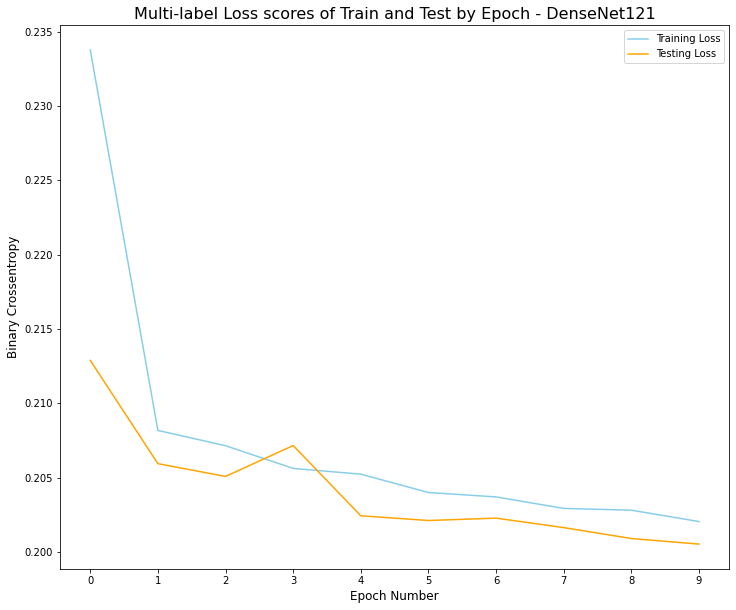

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize = (12, 10))

plt.plot(train_loss, color = 'skyblue', label = 'Training Loss')
plt.plot(test_loss, color = 'orange', label = 'Testing Loss')

plt.title('Multi-label Loss scores of Train and Test by Epoch - DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

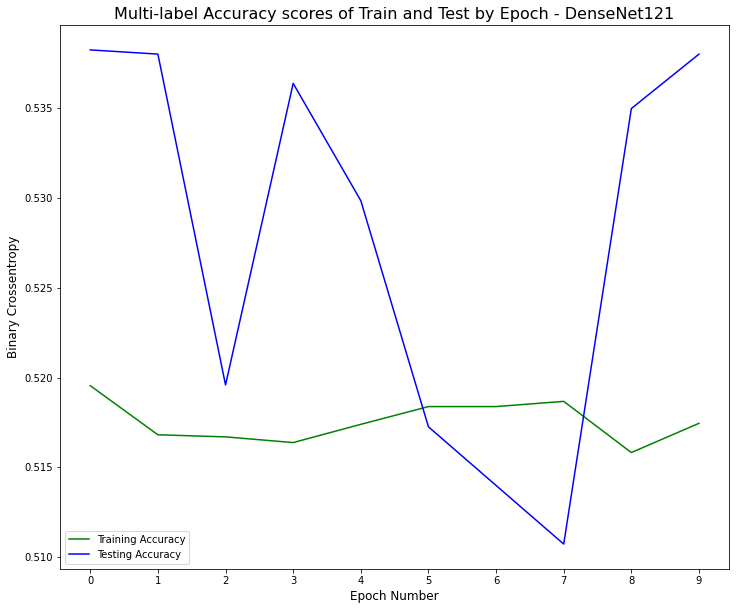

In [ ]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.figure(figsize = (12, 10))

plt.plot(train_acc, color = 'green', label = 'Training Accuracy')
plt.plot(test_acc, color = 'blue', label = 'Testing Accuracy')

plt.title('Multi-label Accuracy scores of Train and Test by Epoch - DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

In [ ]:
pred_classes = (model.predict(training) > 0.5).astype("int32")

In [ ]:
final_labels = [i for i in training.class_indices.keys()]

In [ ]:
pred_classes[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=int32)

In [ ]:
training_predictions = make_preds(pred_classes)

In [ ]:
test_preds = (model.predict(test) > 0.5).astype("int32")

In [ ]:
test_predictions = make_preds(test_preds)

In [ ]:
test_preds[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=int32)

In [ ]:
training.class_indices

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'No Finding': 10,
 'Nodule': 11,
 'Pleural_Thickening': 12,
 'Pneumonia': 13,
 'Pneumothorax': 14}

In [ ]:
training.index_array

array([ 118, 2026, 2567, ...,  350, 5954, 2896])

In [ ]:
df_eval = df_flow.iloc[training.index_array]

In [ ]:
df_eval['model_predictions'] = training_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_eval.head(30)

,index,path,finding_labels_clean,model_predictions
30612,30612,/content/gdrive/MyDrive/Capstone_Images/images...,[Atelectasis],[]
20636,20636,/content/gdrive/MyDrive/Capstone_Images/images...,"[Atelectasis, Effusion]",[No Finding]
38290,38290,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[]
40973,40973,/content/gdrive/MyDrive/Capstone_Images/images...,[Infiltration],[]
37001,37001,/content/gdrive/MyDrive/Capstone_Images/images...,"[Infiltration, Fibrosis]",[No Finding]
102829,102829,/content/gdrive/MyDrive/Capstone_Images/images...,[Infiltration],[No Finding]
99526,99526,/content/gdrive/MyDrive/Capstone_Images/images...,[Edema],[No Finding]
84310,84310,/content/gdrive/MyDrive/Capstone_Images/images...,"[Atelectasis, Effusion, Infiltration, Pleural_...",[No Finding]
10529,10529,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[]
17526,17526,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[]


In [ ]:
df_eval_test = df_flow.iloc[test.index_array]

In [ ]:
df_eval_test['model_predictions'] = test_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_eval_test.head(30)

,index,path,finding_labels_clean,model_predictions
94868,94868,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[No Finding]
17785,17785,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[]
26260,26260,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[No Finding]
70749,70749,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[]
80348,80348,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[No Finding]
58224,58224,/content/gdrive/MyDrive/Capstone_Images/images...,[Infiltration],[No Finding]
47169,47169,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[]
41689,41689,/content/gdrive/MyDrive/Capstone_Images/images...,"[Atelectasis, Pneumothorax]",[No Finding]
25388,25388,/content/gdrive/MyDrive/Capstone_Images/images...,[Edema],[]
109109,109109,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding],[]


This model *technically* predicts multiple classes, however, at the moment it is predicting the majority class only. Review this as you consider methods of collapsing correlated labels.